In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data/imdb-reviews-pt-br.csv', index_col=0)
display(data)

,text_en,text_pt,sentiment
id,,,
1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...,...
49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos


<AxesSubplot: ylabel='count'>

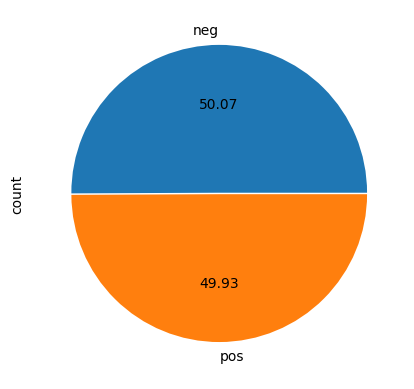

In [3]:
data['sentiment'].value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0])

In [4]:
from sklearn.model_selection import train_test_split

test_dev_size = int(0.05*data.shape[0])
train_dev, test = train_test_split(data, test_size=test_dev_size, random_state=42, stratify=data['sentiment'])
train, dev = train_test_split(train_dev, test_size=test_dev_size, random_state=42, stratify=train_dev['sentiment'])
print('Training samples:', train.shape[0])
print('Dev samples:     ', dev.shape[0])
print('Test samples:    ', test.shape[0])

Training samples: 44515
Dev samples:      2472
Test samples:     2472


In [5]:
from torch.utils.data import Dataset


class ImdbPt(Dataset):
    ''' Loads IMDB-pt dataset. 
    
    It will tokenize our inputs and cut-off sentences that exceed 512 tokens (the pretrained BERT limit)
    '''
    def __init__(self, tokenizer, X, y):
        X = list(X)
        y = list(y)
        tokenized_data = tokenizer(X, truncation=True, max_length=512)
        samples = [
            {
                **{key: tokenized_data[key][i] for key in tokenized_data},
                'labels': y[i]
            }
             
            for i in range(len(X))
        ]
        self.samples = samples
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def __len__(self):
        return len(self.samples)

In [6]:
def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

In [7]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
train_dataset = ImdbPt(tokenizer, train['text_pt'], (train['sentiment'] == 'pos').astype(int))
dev_dataset   = ImdbPt(tokenizer, dev['text_pt'], (dev['sentiment'] == 'pos').astype(int))
test_dataset  = ImdbPt(tokenizer, test['text_pt'], (test['sentiment'] == 'pos').astype(int))

In [8]:


train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer))
dev_loader = DataLoader(dev_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))

In [9]:
import torch 
from transformers import BertForSequenceClassification
from transformers import AdamW

model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased')
model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9997)


for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\João Vitor\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
import numpy as np
def evaluate(model, dev_loader, device):
    with torch.no_grad():
        model.eval()
        dev_losses = []
        tp, tn, fp, fn = [], [], [], []
        for inputs in dev_loader:
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            dev_losses.append(loss.cpu().item())

            _, classification = torch.max(scores, 1)
            labels = inputs['labels']
            tp.append(((classification==1) & (labels==1)).sum().cpu().item())
            tn.append(((classification==0) & (labels==0)).sum().cpu().item())
            fp.append(((classification==1) & (labels==0)).sum().cpu().item())
            fn.append(((classification==0) & (labels==1)).sum().cpu().item())

        tp_s, tn_s, fp_s, fn_s = sum(tp), sum(tn), sum(fp), sum(fn)
        print('Dev loss: {:.2f}; Acc: {:.2f}; tp: {}; tn: {}; fp: {}; fn: {}'.format( 
              np.mean(dev_losses), (tp_s+tn_s)/(tp_s+tn_s+fp_s+fn_s), tp_s, tn_s, fp_s, fn_s))

        model.train()

In [11]:
from tqdm import tqdm_notebook
import os
epoch_bar = tqdm_notebook(range(1))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
    batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Epoch {epoch}', total=len(train_loader))
    for idx, inputs in batch_bar:
        if (epoch * len(train_loader) + idx) == 800:
            for param in model.base_model.parameters():
                param.requires_grad = True

        inputs = send_inputs_to_device(inputs, device)
        optimizer.zero_grad()
        loss, logits = model(**inputs)[:2]
        
        loss.backward()
        optimizer.step()
        if epoch == 0 and idx == 0:
            loss_acc = loss.cpu().item()
        else:
            loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()
        batch_bar.set_postfix(loss=loss_acc)
        if idx%200 == 0:
            del inputs
            del loss
            evaluate(model, dev_loader, device)

        scheduler.step()


        
    os.makedirs('/kaggle/working/checkpoints/epoch'+str(epoch))
    model.save_pretrained('/kaggle/working/checkpoints/epoch'+str(epoch))

C:\Users\João Vitor\AppData\Local\Temp\ipykernel_13944\1419208846.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_bar = tqdm_notebook(range(1))


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\João Vitor\AppData\Local\Temp\ipykernel_13944\1419208846.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Epoch {epoch}', total=len(train_loader))


Epoch 0:   0%|          | 0/5565 [00:00<?, ?it/s]

Dev loss: 0.70; Acc: 0.49; tp: 1184; tn: 37; fp: 1201; fn: 50
Dev loss: 0.70; Acc: 0.50; tp: 1150; tn: 95; fp: 1143; fn: 84
Dev loss: 0.69; Acc: 0.52; tp: 1102; tn: 181; fp: 1057; fn: 132
Dev loss: 0.69; Acc: 0.54; tp: 1050; tn: 273; fp: 965; fn: 184
Dev loss: 0.69; Acc: 0.54; tp: 1050; tn: 287; fp: 951; fn: 184
Dev loss: 0.43; Acc: 0.85; tp: 976; tn: 1123; fp: 115; fn: 258
Dev loss: 0.32; Acc: 0.88; tp: 984; tn: 1184; fp: 54; fn: 250
Dev loss: 0.26; Acc: 0.90; tp: 1149; tn: 1065; fp: 173; fn: 85
Dev loss: 0.24; Acc: 0.91; tp: 1141; tn: 1103; fp: 135; fn: 93
Dev loss: 0.23; Acc: 0.91; tp: 1128; tn: 1127; fp: 111; fn: 106
Dev loss: 0.25; Acc: 0.90; tp: 1167; tn: 1063; fp: 175; fn: 67
Dev loss: 0.24; Acc: 0.91; tp: 1167; tn: 1072; fp: 166; fn: 67
Dev loss: 0.23; Acc: 0.92; tp: 1104; tn: 1159; fp: 79; fn: 130
Dev loss: 0.22; Acc: 0.92; tp: 1130; tn: 1135; fp: 103; fn: 104
Dev loss: 0.23; Acc: 0.91; tp: 1163; tn: 1093; fp: 145; fn: 71
Dev loss: 0.22; Acc: 0.92; tp: 1136; tn: 1133; fp: 105;

In [76]:
import torch
import torch.nn.functional as F
 
inputs = tokenizer("", return_tensors="pt")
output = model(**inputs)
scores = output['logits']
prob_pos = F.softmax(scores, dim=1)[:,1]

limiar_positivo = 0.6
limiar_negativo = 0.4

# Categoriza com base nos limiares
categorias = []
for prob in prob_pos:
    if prob_pos[0] >= limiar_positivo:
        categorias.append("positivo")
    elif prob_pos[0] <= limiar_negativo:
        categorias.append("negativo")
    else:
        categorias.append("neutro")

# categorias agora contém as categorias atribuídas com base nos limiares
print(categorias)

print(prob_pos[0])

['positivo']
tensor(0.6382, grad_fn=<SelectBackward0>)


In [82]:
import pandas as pd
import torch
import torch.nn.functional as F

# Carrega um DataFrame pandas a partir de um arquivo CSV
# Certifique-se de que seu arquivo CSV tem uma coluna chamada 'Frase' que contém as frases
df = pd.read_csv('b2w.csv')  # Substitua 'seuarquivo.csv' pelo caminho para o seu arquivo CSV

# Loop através das frases no DataFrame e classifique-as
categorias = []
for frase in df['review_text_processed']:
    inputs = tokenizer(frase, return_tensors="pt")
    output = model(**inputs)
    scores = output['logits']
    prob_pos = F.softmax(scores, dim=1)[:, 1]

    # Define a categoria com base nos limiares
    if prob_pos[0] >= limiar_positivo:
        categorias.append("positivo")
    elif prob_pos[0] <= limiar_negativo:
        categorias.append("negativo")
    else:
        categorias.append("neutro")

# Adicione as categorias como uma nova coluna no DataFrame
df['Categoria'] = categorias

# Salve o DataFrame modificado em um novo arquivo CSV
df.to_csv('saida.csv', index=False)

# Exibe o DataFrame com as categorias
display(df)
# print(df['Categoria'], ['review_text_processed'])

RuntimeError: The size of tensor a (729) must match the size of tensor b (512) at non-singleton dimension 1